In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Carregar os dados dos filmes
df = pd.read_csv("dados.csv")  # Certifique-se de ter um arquivo CSV com os dados dos filmes

# Pré-processamento dos dados
# Aqui vamos usar apenas título e sinopse como features
text_data = df['Titulo'] + " " + df['Sinopse']

# Vetorização dos dados de texto
vectorizer = TfidfVectorizer(stop_words='english')
text_matrix = vectorizer.fit_transform(text_data)

# Modelo de similaridade
def recommend_movies(input_text, vectorizer, text_matrix, df, top_n=5):
    # Vetorizar o texto de entrada
    input_vector = vectorizer.transform([input_text])
    # Calcular a similaridade do cosseno entre o texto de entrada e os textos dos filmes
    similarities = cosine_similarity(input_vector, text_matrix)
    # Obter os índices dos filmes mais semelhantes
    similar_indices = similarities.argsort(axis=1)[:, ::-1][:, :top_n]
    # Recuperar os filmes recomendados
    recommended_movies = df.iloc[similar_indices[0]]
    return recommended_movies

# Teste do programa
user_input = "Naruto"
recommended_movies = recommend_movies(user_input, vectorizer, text_matrix, df)
recommended_movies[['Titulo', 'Sinopse']]

,Titulo,Sinopse
22,Naruto Shippuden: The Movie,the adventures of adolescent ninja naruto uzum...
26,Naruto the Movie: Ninja Clash in the Land of Snow,naruto sasuke and sakura learn they ll be pro...
20,Naruto Shippûden the Movie: Bonds,when strange ninjas ambush the village of kono...
23,Naruto Shippuden: The Movie: The Lost Tower,when naruto is sent to recover a missing nin ...
4707,Naruto Shippuden : Blood Prison,mistakenly accused of an attack on the fourth ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5688 entries, 0 to 5687
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Titulo     5688 non-null   object
 1   Pais       5688 non-null   object
 2   Ano        5688 non-null   int64 
 3   Minutagem  5688 non-null   int64 
 4   Genero     5688 non-null   object
 5   Sinopse    5688 non-null   object
dtypes: int64(2), object(4)
memory usage: 266.8+ KB


Verdadeiro Positivo: 48
Falso Positivo: 0
Verdadeiro Negativo: 31
Falso Negativo: 1
Acurácia: 0.6278366111951589


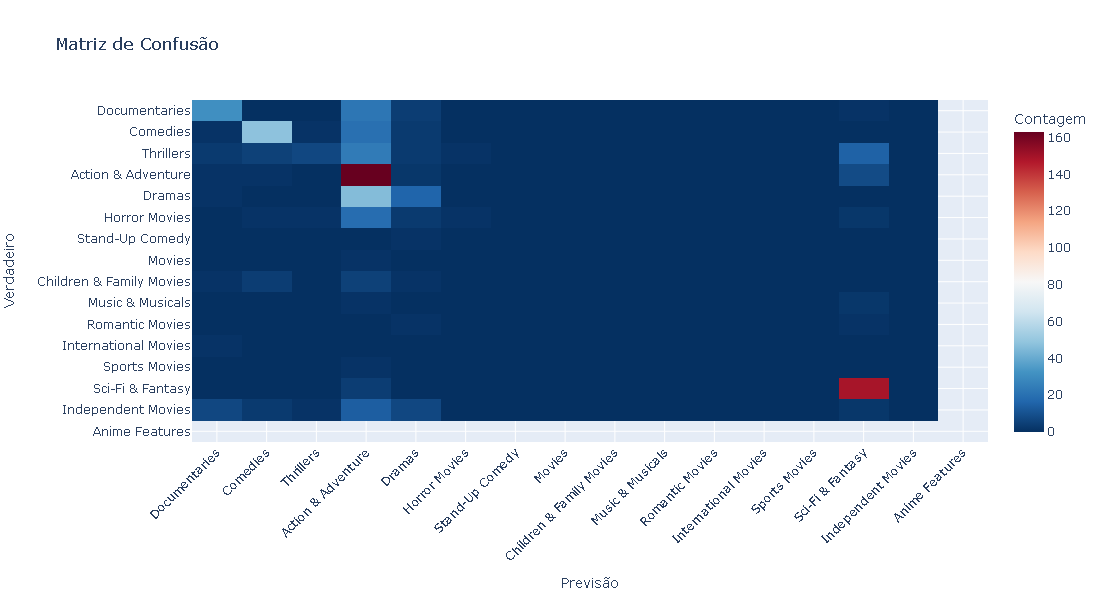

In [46]:
import pandas as pd
import plotly.graph_objs as go
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

# Carregar os dados dos filmes
df = pd.read_csv("dados.csv")  # Certifique-se de ter um arquivo CSV com os dados dos filmes

# Filtrar filmes com gênero único
df = df[df['Genero'].apply(lambda x: len(x.split(',')) == 1)]

# Definir X e Y
X = df.drop('Genero', axis=1)  # Todas as colunas exceto 'Genero'
Y = df['Genero']

# Dividir os dados em conjunto de treinamento e conjunto de teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=32)

# Pré-processamento dos dados de texto
text_data_train = X_train['Titulo'] + " " + X_train['Sinopse']
text_data_test = X_test['Titulo'] + " " + X_test['Sinopse']

# Vetorização dos dados de texto
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(text_data_train)
X_test_vectorized = vectorizer.transform(text_data_test)

# Treinar o modelo SVM
model = SVC(kernel='linear')
model.fit(X_train_vectorized, Y_train)

# Fazer previsões no conjunto de teste
predictions = model.predict(X_test_vectorized)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(Y_test, predictions)

# Calculando verdadeiro positivo, falso positivo, verdadeiro negativo e falso negativo
VP = conf_matrix[1][1]  # Verdadeiro Positivo
FP = conf_matrix[0][1]  # Falso Positivo
VN = conf_matrix[0][0]  # Verdadeiro Negativo
FN = conf_matrix[1][0]  # Falso Negativo

print("Verdadeiro Positivo:", VP)
print("Falso Positivo:", FP)
print("Verdadeiro Negativo:", VN)
print("Falso Negativo:", FN)

# Calculando as métricas de acurácia
accuracy = accuracy_score(Y_test, predictions)
print("Acurácia:", accuracy)

# Plotar a matriz de confusão com Plotly
labels = df['Genero'].unique()
trace = go.Heatmap(z=conf_matrix,
                   x=labels,
                   y=labels,
                   colorscale='RdBu',
                   reversescale=True,
                   zmin=0,
                   zmax=conf_matrix.max(),
                   colorbar=dict(title='Contagem'))
layout = go.Layout(title='Matriz de Confusão',
                   xaxis=dict(title='Previsão', tickangle=-45),
                   yaxis=dict(title='Verdadeiro', autorange='reversed'))
fig = go.Figure(data=[trace], layout=layout)
fig.update_layout(width=800, height=600, font=dict(size=12))
fig.show()


Verdadeiro Positivo: 10
Falso Positivo: 5
Verdadeiro Negativo: 12
Falso Negativo: 3
Acurácia: 0.37065052950075644


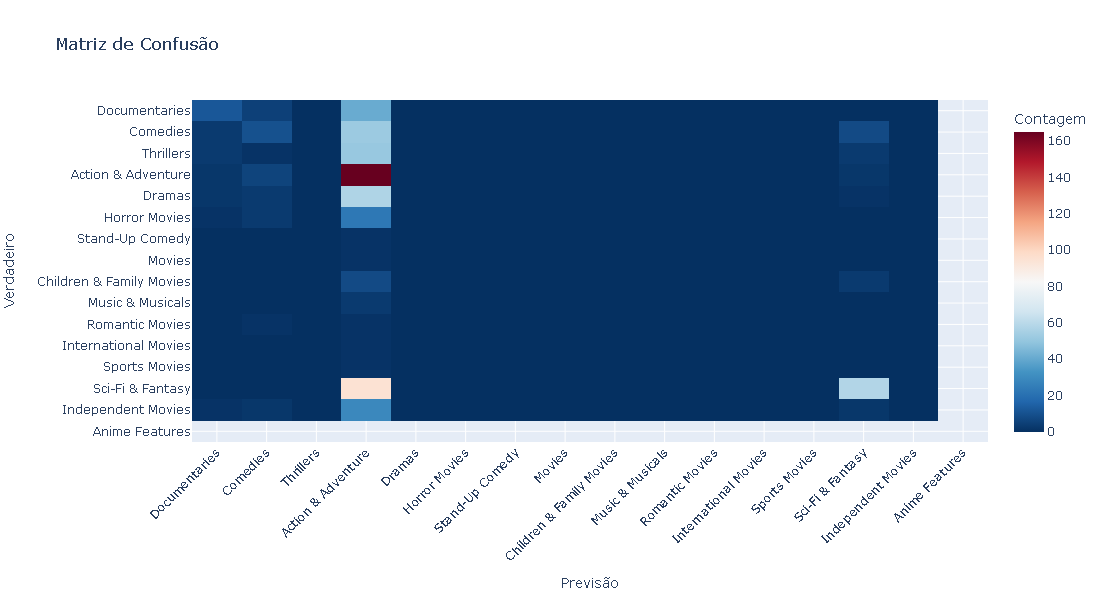

In [40]:
import pandas as pd
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.sparse import hstack

# Carregar os dados dos filmes
df = pd.read_csv("dados.csv")  # Certifique-se de ter um arquivo CSV com os dados dos filmes

# Filtrar filmes com gênero único
df = df[df['Genero'].apply(lambda x: len(x.split(',')) == 1)]

# Definir X e Y
X_text = df['Titulo'] + " " + df['Sinopse']  # Dados de texto: título + sinopse
X_categorical = df[['Pais']]  # Dados categóricos: país
Y = df['Genero']

# Dividir os dados em conjunto de treinamento e conjunto de teste
X_text_train, X_text_test, X_categorical_train, X_categorical_test, Y_train, Y_test = train_test_split(X_text, X_categorical, Y, test_size=0.5, random_state=32)

# Vetorização dos dados de texto
vectorizer = TfidfVectorizer(stop_words='english')
X_text_train_vectorized = vectorizer.fit_transform(X_text_train)
X_text_test_vectorized = vectorizer.transform(X_text_test)

# Codificar características categóricas (One-Hot Encoding)
column_transformer = ColumnTransformer(
    [('encoder', OneHotEncoder(handle_unknown='ignore'), ['Pais'])], 
    remainder='passthrough'
)
X_categorical_train_encoded = column_transformer.fit_transform(X_categorical_train)
X_categorical_test_encoded = column_transformer.transform(X_categorical_test)

# Concatenar dados de texto vetorizados com dados categóricos codificados
X_train = hstack((X_text_train_vectorized, X_categorical_train_encoded))
X_test = hstack((X_text_test_vectorized, X_categorical_test_encoded))

# Treinar o modelo SVM
model = SVC(kernel='rbf', C=100, gamma=0.001)  # Usando um kernel radial, uma penalidade C maior e um gamma menor
model.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
predictions = model.predict(X_test)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(Y_test, predictions)

# Calculando verdadeiro positivo, falso positivo, verdadeiro negativo e falso negativo
VP = conf_matrix[1][1]  # Verdadeiro Positivo
FP = conf_matrix[0][1]  # Falso Positivo
VN = conf_matrix[0][0]  # Verdadeiro Negativo
FN = conf_matrix[1][0]  # Falso Negativo

print("Verdadeiro Positivo:", VP)
print("Falso Positivo:", FP)
print("Verdadeiro Negativo:", VN)
print("Falso Negativo:", FN)

# Calculando as métricas de acurácia
accuracy = accuracy_score(Y_test, predictions)
print("Acurácia:", accuracy)

# Plotar a matriz de confusão com Plotly
labels = df['Genero'].unique()
trace = go.Heatmap(z=conf_matrix,
                   x=labels,
                   y=labels,
                   colorscale='RdBu',
                   reversescale=True,
                   zmin=0,
                   zmax=conf_matrix.max(),
                   colorbar=dict(title='Contagem'))
layout = go.Layout(title='Matriz de Confusão',
                   xaxis=dict(title='Previsão', tickangle=-45),
                   yaxis=dict(title='Verdadeiro', autorange='reversed'))
fig = go.Figure(data=[trace], layout=layout)
fig.update_layout(width=800, height=600, font=dict(size=12))
fig.show()